In [1]:
import numpy as np
import xarray as xr
import scipy.stats as st
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import requests
import os,errno
import sys
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER,LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import datetime as dt
import pandas as pd
import time
import urllib.request
import metpy.calc as mpcalc
import salem
import scipy.optimize as opt
import warnings
import geopy.distance
import matplotlib as mpl

from scipy.ndimage.measurements import label
from scipy.ndimage import binary_dilation

warnings.filterwarnings('ignore')

dir_data='/Users/ahenny/'
dir2='/Volumes/Extreme Pro/'
dir3='/Volumes/My Passport/'

/var/folders/6s/v2ptr27x1537n4_9dh_x4n0h0000gq/T/ipykernel_34642/808188560.py:23: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


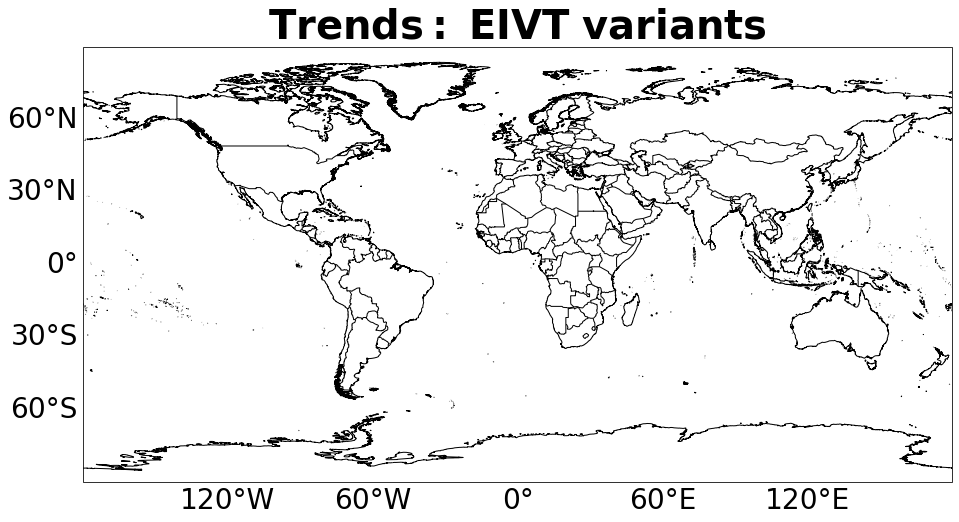

In [8]:
fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())


g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':28,'color':'k'}
g1.ylabel_style={'size':28,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
#ax.set_title(r'$\bf{\#}$'+' '+r'$\bf{datasets:}$'+' '+r'$\bf{AR}$'+' '+r'$\bf{variants}$',fontsize=40,pad=5)
ax.set_title(r'$\bf{Trends:}$'+' '+r'$\bf{EIVT}$'+' '+r'$\bf{variants}$',fontsize=40,pad=5)

plt.show()

In [9]:
fig.savefig(dir_data+'titles_redo_4.png')

In [ ]:
yrs=np.arange(1980,2024,1)

ds=xr.open_dataset(dir2+'merra2_ivt_threshold.nc')
merra2_threshold=ds['threshold']
ds=xr.open_dataset(dir2+'era_5_ivt_threshold.nc')
era5_threshold=ds['threshold']
ds=xr.open_dataset(dir3+'jra55_ivt_threshold.nc')
jra55_threshold=ds['threshold']

ds=xr.open_dataset(dir2+'merra2.ar.labels.model.variable.'+str(2023)+'.nc')
lons=ds.lon.values
lats=ds.lat.values

merra2_threshold['lon']=lons
merra2_threshold['lat']=lats
era5_threshold['lon']=lons
era5_threshold['lat']=lats

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir3+'jra55_ivt_'+str(year)+'.nc')
    ivt_jra55=ds['ivt']
    
    
    ar=ivt_jra55.where(ivt_jra55>=jra55_threshold)
    ar=ar/ar
    freq_jra55_polar=ar.sum(dim='time',skipna=True)
    
    ar=ivt_jra55.where(ivt_jra55>=300)
    ar=ar/ar
    freq_jra55_fixed=ar.sum(dim='time',skipna=True)
    
    
    if i==0:
        freq_concat_jra55_polar=freq_jra55_polar
        freq_concat_jra55_fixed=freq_jra55_fixed
    else:
        freq_concat_jra55_polar=xr.concat([freq_concat_jra55_polar,freq_jra55_polar],dim='time')
        freq_concat_jra55_fixed=xr.concat([freq_concat_jra55_fixed,freq_jra55_fixed],dim='time')
    

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir2+'merra2.ivt.3hr.model.'+str(year)+'.nc')
    ivt_merra2=ds['ivt'][0::2,:,:]
    
    ivt_merra2['lon']=lons
    ivt_merra2['lat']=lats
    
    ar=ivt_merra2.where(ivt_merra2>=merra2_threshold)
    ar=ar/ar
    freq_merra2_polar=ar.sum(dim='time',skipna=True)
    
    ar=ivt_merra2.where(ivt_merra2>=300)
    ar=ar/ar
    freq_merra2_fixed=ar.sum(dim='time',skipna=True)
    
    if i==0:
        freq_concat_merra2_polar=freq_merra2_polar
        freq_concat_merra2_fixed=freq_merra2_fixed
    else:
        freq_concat_merra2_polar=xr.concat([freq_concat_merra2_polar,freq_merra2_polar],dim='time')
        freq_concat_merra2_fixed=xr.concat([freq_concat_merra2_fixed,freq_merra2_fixed],dim='time')

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir2+'era_5_ivtinterp_'+str(year)+'.nc')
    ivt_era5=ds['ivt']
    
    ivt_era5['lon']=lons
    ivt_era5['lat']=lats
    
    ar=ivt_era5.where(ivt_era5>=era5_threshold)
    ar=ar/ar
    freq_era5_polar=ar.sum(dim='time',skipna=True)
    
    ar=ivt_era5.where(ivt_era5>=300)
    ar=ar/ar
    freq_era5_fixed=ar.sum(dim='time',skipna=True)
    
    if i==0:
        freq_concat_era5_polar=freq_era5_polar
        freq_concat_era5_fixed=freq_era5_fixed
    else:
        freq_concat_era5_polar=xr.concat([freq_concat_era5_polar,freq_era5_polar],dim='time')
        freq_concat_era5_fixed=xr.concat([freq_concat_era5_fixed,freq_era5_fixed],dim='time')

In [ ]:
lons_west=[x for x in freq_concat_jra55_polar.lon.values if x<-90]
lons_east=[x for x in freq_concat_jra55_polar.lon.values if x>=90]
sel_west=freq_concat_jra55_polar.sel(lon=lons_west)
sel_east=freq_concat_jra55_polar.sel(lon=lons_east)
sel_west['lon']=[x+360. for x in lons_west]
sel_east['lon']=[x-360. for x in lons_east]
final=xr.concat([sel_east,freq_concat_jra55_polar,sel_west],dim='lon')
interp=final.interp(lat=freq_concat_era5_polar.lat.values,lon=freq_concat_era5_polar.lon.values)
lons_center=[x for x in interp.lon.values if -180<=x<180]
freq_concat_jra55_polar1=interp.sel(lon=lons_center)


sel_west=freq_concat_jra55_fixed.sel(lon=lons_west)
sel_east=freq_concat_jra55_fixed.sel(lon=lons_east)
sel_west['lon']=[x+360. for x in lons_west]
sel_east['lon']=[x-360. for x in lons_east]
final=xr.concat([sel_east,freq_concat_jra55_fixed,sel_west],dim='lon')
interp=final.interp(lat=freq_concat_era5_polar.lat.values,lon=freq_concat_era5_polar.lon.values)
lons_center=[x for x in interp.lon.values if -180<=x<180]
freq_concat_jra55_fixed1=interp.sel(lon=lons_center)

In [ ]:
field=freq_concat_era5_fixed.mean(dim='time',skipna=True)

from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

cmap1=plt.cm.viridis(np.linspace(0,1,128))
cmap2=LinearSegmentedColormap.from_list('cmap2',[cmap1[-1],'orange'])
cmap2=cmap2(np.linspace(0,1,32))
colors=np.vstack((cmap1,cmap2))
cmap_new=LinearSegmentedColormap.from_list('cmap_new',colors)

fig=plt.figure(figsize=(24,11))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#c=ax.contour(field.lon.values,field.lat.values,field/4.,levels=np.arange(20,240,40),colors='k',linewidths=2.0,alpha=0.96)
#plt.clabel(c,fmt='%.00f',fontsize=15,inline=True)

#cax=ax.pcolormesh(field.lon,field.lat,field/4.,vmin=0,vmax=130,cmap=plt.cm.viridis,transform=ccrs.PlateCarree(),alpha=1.0)   
cax=ax.contourf(field.lon,field.lat,field/4.,levels=np.arange(0,140,10),cmap=plt.cm.viridis,extend='max',transform=ccrs.PlateCarree(),alpha=1.0)   

cbar=plt.colorbar(cax,pad=0,fraction=0.046,extend='max',aspect=25,ticks=np.arange(20,140,20))

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=35) 
cbar.set_label('days yr$^{-1}$',fontsize=38,labelpad=5)
ax.coastlines(resolution='10m',color='w')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none',edgecolor='w')
ax.add_feature(countries)
g1.xlabel_style={'size':35,'color':'k'}
g1.ylabel_style={'size':35,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
#g1.left_labels=False
#g1.bottom_labels=False
#ax.set_title(r'$\bf{MERRA-2}$'+' '+r'$\bf{variable}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{MERRA-2}$'+' '+r'$\bf{fixed}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{MERRA-2}$'+' '+r'$\bf{fixed}$'+' '+r'$\bf{poleward}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{ERA5}$'+' '+r'$\bf{variable}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{ERA5}$'+' '+r'$\bf{fixed}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{ERA5}$'+' '+r'$\bf{fixed}$'+' '+r'$\bf{poleward}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{JRA-55}$'+' '+r'$\bf{variable}$',fontsize=52,pad=5)
#ax.set_title(r'$\bf{JRA-55}$'+' '+r'$\bf{fixed}$',fontsize=52,pad=5)
ax.set_title(r'$\bf{JRA-55}$'+' '+r'$\bf{fixed}$'+' '+r'$\bf{poleward}$',fontsize=52,pad=5)
plt.show()

In [ ]:
fig.savefig(dir_data+'ar_final_geomeans_9.png')

In [ ]:
yrs=np.arange(1980,2024,1)
slopes_array_merra2_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_merra2_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
slopes_array_merra2_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_merra2_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])

slopes_array_era5_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_era5_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
slopes_array_era5_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_era5_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])

slopes_array_jra55_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_jra55_polar=xr.zeros_like(freq_concat_era5_polar[0,:,:])
slopes_array_jra55_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])
sigs_array_jra55_fixed=xr.zeros_like(freq_concat_era5_polar[0,:,:])
yrs=np.arange(1980,2024,1)
size=20
for j in range(freq_concat_merra2_polar.lat.size):
    print(j)
    for k in range(freq_concat_merra2_polar.lon.size):
        
        time_series=freq_concat_jra55_polar1[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_jra55_polar[j,k]=r[0]
            sigs_array_jra55_polar[j,k]=r[3]
        else:
            slopes_array_jra55_polar[j,k]=np.nan
            sigs_array_jra55_polar[j,k]=np.nan
        
        time_series=freq_concat_jra55_fixed1[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_jra55_fixed[j,k]=r[0]
            sigs_array_jra55_fixed[j,k]=r[3]
        else:
            slopes_array_jra55_fixed[j,k]=np.nan
            sigs_array_jra55_fixed[j,k]=np.nan
        
        time_series=freq_concat_merra2_polar[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_merra2_polar[j,k]=r[0]
            sigs_array_merra2_polar[j,k]=r[3]
        else:
            slopes_array_merra2_polar[j,k]=np.nan
            sigs_array_merra2_polar[j,k]=np.nan
        
        time_series=freq_concat_merra2_fixed[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_merra2_fixed[j,k]=r[0]
            sigs_array_merra2_fixed[j,k]=r[3]
        else:
            slopes_array_merra2_fixed[j,k]=np.nan
            sigs_array_merra2_fixed[j,k]=np.nan
        
        time_series=freq_concat_era5_polar[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_era5_polar[j,k]=r[0]
            sigs_array_era5_polar[j,k]=r[3]
        else:
            slopes_array_era5_polar[j,k]=np.nan
            sigs_array_era5_polar[j,k]=np.nan
        
        time_series=freq_concat_era5_fixed[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>=size:
            r=st.linregress(yrs,time_series)
            slopes_array_era5_fixed[j,k]=r[0]
            sigs_array_era5_fixed[j,k]=r[3]
        else:
            slopes_array_era5_fixed[j,k]=np.nan
            sigs_array_era5_fixed[j,k]=np.nan

In [ ]:
dk=xr.Dataset()
dk['slopes_array_era5_variable']=(('lat','lon'),slopes_array_era5_polar.values)
dk['slopes_array_era5_fixed']=(('lat','lon'),slopes_array_era5_fixed.values)

dk['slopes_array_jra55_variable']=(('lat','lon'),slopes_array_jra55_polar.values)
dk['slopes_array_jra55_fixed']=(('lat','lon'),slopes_array_jra55_fixed.values)

dk['slopes_array_merra2_variable']=(('lat','lon'),slopes_array_merra2_polar.values)
dk['slopes_array_merra2_fixed']=(('lat','lon'),slopes_array_merra2_fixed.values)

dk['sigs_array_era5_variable']=(('lat','lon'),sigs_array_era5_polar.values)
dk['sigs_array_era5_fixed']=(('lat','lon'),sigs_array_era5_fixed.values)

dk['sigs_array_jra55_variable']=(('lat','lon'),sigs_array_jra55_polar.values)
dk['sigs_array_jra55_fixed']=(('lat','lon'),sigs_array_jra55_fixed.values)

dk['sigs_array_merra2_variable']=(('lat','lon'),sigs_array_merra2_polar.values)
dk['sigs_array_merra2_fixed']=(('lat','lon'),sigs_array_merra2_fixed.values)

dk.coords['lat']=slopes_array_era5_polar.lat.values
dk.coords['lon']=slopes_array_era5_polar.lon.values

dk['lat'].attrs["units"]='degrees_north'
dk['lon'].attrs["units"]='degrees_east'

try:
    os.remove(dir_data+'ivt_geoslopes_variants.nc')
except OSError:
    pass
dk.to_netcdf(dir_data+'ivt_geoslopes_variants.nc',mode='w',format='NETCDF4')

In [ ]:
N=sigs_array_merra2_polar.lat.size*sigs_array_merra2_polar.lon.size
a=0.05#/sum_factor

p_values=sorted(sigs_array_merra2_polar.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)

print(N)
print(len([x for x in p_values if x>=0]))

pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
p_final=max(pass_list)
print(p_final)
sigs_array_final_merra2_polar=sigs_array_merra2_polar.where(sigs_array_merra2_polar<=p_final)


p_values=sorted(sigs_array_merra2_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
p_final=max(pass_list)
print(p_final)
sigs_array_final_merra2_fixed=sigs_array_merra2_fixed.where(sigs_array_merra2_fixed<=p_final)

########

N=sigs_array_era5_polar.lat.size*sigs_array_era5_polar.lon.size
p_values=sorted(sigs_array_era5_polar.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)

print(N)
print(len([x for x in p_values if x>=0]))

pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_era5_polar=sigs_array_era5_polar.where(sigs_array_era5_polar<=p_final)


p_values=sorted(sigs_array_era5_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_era5_fixed=sigs_array_era5_fixed.where(sigs_array_era5_fixed<=p_final)

############

N=sigs_array_jra55_polar.lat.size*sigs_array_jra55_polar.lon.size
p_values=sorted(sigs_array_jra55_polar.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)

print(N)
print(len([x for x in p_values if x>=0]))

pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_jra55_polar=sigs_array_jra55_polar.where(sigs_array_jra55_polar<=p_final)


p_values=sorted(sigs_array_jra55_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_jra55_fixed=sigs_array_jra55_fixed.where(sigs_array_jra55_fixed<=p_final)

In [ ]:
num_sets1=xr.ones_like(slopes_array_merra2_polar).where(slopes_array_merra2_polar>-1000)
num_sets1=num_sets1.fillna(0)
num_sets2=xr.ones_like(slopes_array_merra2_fixed).where(slopes_array_merra2_fixed>-1000)
num_sets2=num_sets2.fillna(0)

num_sets4=xr.ones_like(slopes_array_era5_polar).where(slopes_array_era5_polar>-1000)
num_sets4=num_sets4.fillna(0)
num_sets5=xr.ones_like(slopes_array_era5_fixed).where(slopes_array_era5_fixed>-1000)
num_sets5=num_sets5.fillna(0)

num_sets7=xr.ones_like(slopes_array_jra55_polar).where(slopes_array_jra55_polar>-1000)
num_sets7=num_sets7.fillna(0)
num_sets8=xr.ones_like(slopes_array_jra55_fixed).where(slopes_array_jra55_fixed>-1000)
num_sets8=num_sets8.fillna(0)


#num_sets1['lon']=num_sets4.lon.values
#num_sets2['lon']=num_sets4.lon.values
#num_sets1['lat']=num_sets4.lat.values
#num_sets2['lat']=num_sets4.lat.values

num_sets=num_sets1+num_sets2+num_sets4+num_sets5+num_sets7+num_sets8
field=num_sets


fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(field.lon,field.lat,field.where(field>0),levels=np.arange(0,7,1),cmap=plt.cm.Greens,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,7,1))

#cax=ax.contourf(field.lon,field.lat,field,levels=np.arange(-2,2.2,0.2),cmap=plt.cm.seismic,extend='both',transform=ccrs.PlateCarree(),alpha=1.0)   


g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=32) 
cbar.set_label('# datasets',fontsize=36,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':28,'color':'k'}
g1.ylabel_style={'size':28,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False
#ax.set_ylim(-60,70)

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{\#}$'+' '+r'$\bf{datasets:}$'+' '+r'$\bf{2}$'+' '+r'$\bf{EIVT}$'+' '+r'$\bf{variants}$',fontsize=40,pad=5)

plt.show()

In [ ]:
#fig.savefig(dir_data+'ivt_trend_datasetsa_new.png')
fig.savefig(dir_data+'artmip_redo_4.png')

In [ ]:
ds=xr.open_dataset(dir_data+'merra2_gridareas.nc')
areas=ds['cell_area']
test1=areas.where(test_all>=0.666).sum()
test2=areas.sum()
ratio=test1/test2
print(ratio)

In [ ]:
#To get % of EIVT from ARs
mean1=freq_concat_merra2_polar.mean(dim='time',skipna=True)
mean2=freq_concat_merra2_fixed.mean(dim='time',skipna=True)

mean4=freq_concat_era5_polar.mean(dim='time',skipna=True)
mean5=freq_concat_era5_fixed.mean(dim='time',skipna=True)

mean7=freq_concat_jra55_polar.mean(dim='time',skipna=True)
mean8=freq_concat_jra55_fixed.mean(dim='time',skipna=True)

mean7=mean7.interp_like(mean1)
mean8=mean8.interp_like(mean1)

mean_all=(mean1+mean2+mean4+mean5+mean7+mean8)/6.


ds=xr.open_dataset(dir_data+'merra2_gridareas.nc')
areas=ds['cell_area']
test1=mean_all*areas
test1=test1.sum().values.tolist()
print(test1)

In [ ]:
test1=xr.ones_like(sigs_array_final_merra2_polar).where(sigs_array_final_merra2_polar<=0.05).where(slopes_array_merra2_polar>0).fillna(0)
test2=xr.ones_like(sigs_array_final_merra2_fixed).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed>0).fillna(0)
test4=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_final_era5_polar<=0.05).where(slopes_array_era5_polar>0).fillna(0)
test5=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed>0).fillna(0)
test7=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_final_jra55_polar<=0.05).where(slopes_array_jra55_polar>0).fillna(0)
test8=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed>0).fillna(0)

test_all=(test1+test2+test4+test5+test7+test8)/num_sets
field=test_all


test1a=xr.ones_like(sigs_array_final_merra2_polar).where(sigs_array_final_merra2_polar<=0.05).where(slopes_array_merra2_polar<0).fillna(0)
test2a=xr.ones_like(sigs_array_final_merra2_fixed).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed<0).fillna(0)
test4a=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_final_era5_polar<=0.05).where(slopes_array_era5_polar<0).fillna(0)
test5a=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed<0).fillna(0)
test7a=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_final_jra55_polar<=0.05).where(slopes_array_jra55_polar<0).fillna(0)
test8a=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed<0).fillna(0)

test_alla=(test1a+test2a+test4a+test5a+test7a+test8a)/num_sets
fielda=test_alla

fieldb=field.where(field==fielda)
fieldb=fieldb/fieldb
field=field.where(field>fielda).fillna(0)
fielda=fielda.where(fielda>field)

#####LENIENT


test1b=xr.ones_like(sigs_array_final_merra2_polar).where(sigs_array_merra2_polar<=0.05).where(slopes_array_merra2_polar>0).fillna(0)
test2b=xr.ones_like(sigs_array_final_merra2_fixed).where(sigs_array_merra2_fixed<=0.05).where(slopes_array_merra2_fixed>0).fillna(0)
test4b=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_era5_polar<=0.05).where(slopes_array_era5_polar>0).fillna(0)
test5b=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_era5_fixed<=0.05).where(slopes_array_era5_fixed>0).fillna(0)
test7b=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_jra55_polar<=0.05).where(slopes_array_jra55_polar>0).fillna(0)
test8b=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_jra55_fixed<=0.05).where(slopes_array_jra55_fixed>0).fillna(0)

test_allb=(test1b+test2b+test4b+test5b+test7b+test8b)/num_sets


test1c=xr.ones_like(sigs_array_final_merra2_polar).where(sigs_array_merra2_polar<=0.05).where(slopes_array_merra2_polar<0).fillna(0)
test2c=xr.ones_like(sigs_array_final_merra2_fixed).where(sigs_array_merra2_fixed<=0.05).where(slopes_array_merra2_fixed<0).fillna(0)
test4c=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_era5_polar<=0.05).where(slopes_array_era5_polar<0).fillna(0)
test5c=xr.ones_like(sigs_array_final_era5_polar).where(sigs_array_era5_fixed<=0.05).where(slopes_array_era5_fixed<0).fillna(0)
test7c=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_jra55_polar<=0.05).where(slopes_array_jra55_polar<0).fillna(0)
test8c=xr.ones_like(sigs_array_final_jra55_polar).where(sigs_array_jra55_fixed<=0.05).where(slopes_array_jra55_fixed<0).fillna(0)

test_allc=(test1c+test2c+test4c+test5c+test7c+test8c)/num_sets


from matplotlib.colors import LinearSegmentedColormap
colors1=plt.cm.Reds(np.linspace(0,1,128))
colors2=plt.cm.Blues_r(np.linspace(0,1,128))
colors=np.vstack((colors2,colors1))
cmap_new=LinearSegmentedColormap.from_list('cmap_new',colors)

fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#field=sigs_array_era5_polar#.mean(dim='time',skipna=True)
#cax=ax.pcolormesh(field.lon,field.lat,field/field,vmin=0,vmax=1,cmap=plt.cm.Blues)
cax=ax.contourf(field.lon,field.lat,field.where(field>0)*100.,levels=np.arange(-100,110,10),cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
#cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,10,1))

cax=ax.contourf(field.lon,field.lat,fielda.where(fielda>0)*-100.,levels=np.arange(-100,110,10),cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(-100,120,20),extend='None')
cbar.ax.set_yticklabels([' ','80','60','40','20','0','20','40','60','80',' '])

cmap_new=LinearSegmentedColormap.from_list('cmap_new',['w','magenta'])
cax=ax.pcolormesh(fieldb.lon,fieldb.lat,fieldb,vmin=0,vmax=1.0,cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   

X=4
for j in range(int(field.lat.size/X)):
    for k in range(int(field.lon.size/X)):
        if test_allb[X*j,X*k]*100.>=66.66 or test_allc[X*j,X*k]*100.>=66.66:
            ax.plot(field.lon[X*k],field.lat[X*j],marker='o',color='k',markersize=2,alpha=0.5)

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=32) 
cbar.set_label('% datasets',fontsize=36,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':28,'color':'k'}
g1.ylabel_style={'size':28,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{Trends:}$'+' '+r'$\bf{2}$'+' '+r'$\bf{EIVT}$'+' '+r'$\bf{variants}$',fontsize=40,pad=5)

plt.show()

In [ ]:
#fig.savefig(dir_data+'ivt_final_summary_1_new.png')
fig.savefig(dir_data+'artmip_redo_6.png')

In [ ]:
mean=freq_concat_merra2_polar.mean(dim='time',skipna=True)
num_sets1=xr.ones_like(slopes_array_merra2_polar).where(mean>0.5).fillna(0)
mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
num_sets2=xr.ones_like(slopes_array_merra2_fixed).where(mean>0.5).fillna(0)

mean=freq_concat_era5_polar.mean(dim='time',skipna=True)
num_sets4=xr.ones_like(slopes_array_era5_polar).where(mean>0.5).fillna(0)
mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
num_sets5=xr.ones_like(slopes_array_era5_fixed).where(mean>0.5).fillna(0)

mean=freq_concat_jra55_polar.mean(dim='time',skipna=True)
num_sets7=xr.ones_like(slopes_array_jra55_polar).where(mean>0.5).fillna(0)
mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
num_sets8=xr.ones_like(slopes_array_jra55_fixed).where(mean>0.5).fillna(0)

num_sets7=num_sets7.interp_like(num_sets1)
num_sets8=num_sets8.interp_like(num_sets1)

num_sets=num_sets1+num_sets2+num_sets4+num_sets5+num_sets7+num_sets8
field=num_sets


fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(field.lon,field.lat,field.where(field>0),levels=np.arange(0,7,1),cmap=plt.cm.Reds,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,7,1))

#cax=ax.contourf(field.lon,field.lat,field,levels=np.arange(-2,2.2,0.2),cmap=plt.cm.seismic,extend='both',transform=ccrs.PlateCarree(),alpha=1.0)   


g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=36) 
cbar.set_label('# datasets',fontsize=42,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':36,'color':'k'}
g1.ylabel_style={'size':36,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False
ax.set_ylim(-60,70)

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{Number}$'+' '+r'$\bf{of}$'+' '+r'$\bf{EIVT}$'+' '+r'$\bf{datasets}$'+' ',fontsize=48,pad=5)

plt.show()

In [ ]:
fig.savefig(dir_data+'ivt_trend_datasets.png')

In [ ]:
mean=freq_concat_merra2_polar.mean(dim='time',skipna=True)
test1=xr.ones_like(sigs_array_final_merra2_polar).where(mean>0.5).where(sigs_array_final_merra2_polar<=0.05).where(slopes_array_merra2_polar>0).fillna(0)
mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
test2=xr.ones_like(sigs_array_final_merra2_fixed).where(mean>0.5).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed>0).fillna(0)
mean=freq_concat_era5_polar.mean(dim='time',skipna=True)
test4=xr.ones_like(sigs_array_final_era5_polar).where(mean>0.5).where(sigs_array_final_era5_polar<=0.05).where(slopes_array_era5_polar>0).fillna(0)
mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
test5=xr.ones_like(sigs_array_final_era5_polar).where(mean>0.5).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed>0).fillna(0)
mean=freq_concat_jra55_polar.mean(dim='time',skipna=True)
test7=xr.ones_like(sigs_array_final_jra55_polar).where(mean>0.5).where(sigs_array_final_jra55_polar<=0.05).where(slopes_array_jra55_polar>0).fillna(0)
mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
test8=xr.ones_like(sigs_array_final_jra55_polar).where(mean>0.5).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed>0).fillna(0)

test7=test7.interp_like(test1)
test8=test8.interp_like(test1)


test_all=(test1+test2+test4+test5+test7+test8)/num_sets
sigs_pos=test_all


mean=freq_concat_merra2_polar.mean(dim='time',skipna=True)
test1a=xr.ones_like(sigs_array_final_merra2_polar).where(mean>0.5).where(sigs_array_final_merra2_polar<=0.05).where(slopes_array_merra2_polar<0).fillna(0)
mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
test2a=xr.ones_like(sigs_array_final_merra2_fixed).where(mean>0.5).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed<0).fillna(0)
mean=freq_concat_era5_polar.mean(dim='time',skipna=True)
test4a=xr.ones_like(sigs_array_final_era5_polar).where(mean>0.5).where(sigs_array_final_era5_polar<=0.05).where(slopes_array_era5_polar<0).fillna(0)
mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
test5a=xr.ones_like(sigs_array_final_era5_polar).where(mean>0.5).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed<0).fillna(0)
mean=freq_concat_jra55_polar.mean(dim='time',skipna=True)
test7a=xr.ones_like(sigs_array_final_jra55_polar).where(mean>0.5).where(sigs_array_final_jra55_polar<=0.05).where(slopes_array_jra55_polar<0).fillna(0)
mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
test8a=xr.ones_like(sigs_array_final_jra55_polar).where(mean>0.5).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed<0).fillna(0)

test7a=test7a.interp_like(test1a)
test8a=test8a.interp_like(test1a)


test_alla=(test1a+test2a+test4a+test5a+test7a+test8a)/num_sets
sigs_neg=test_alla

In [ ]:
mean=freq_concat_merra2_polar.mean(dim='time',skipna=True)
test1=slopes_array_merra2_polar/mean*100.
test1=test1.where(mean>0.5).fillna(0)

mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
test2=slopes_array_merra2_fixed/mean*100.
test2=test2.where(mean>0.5).fillna(0)


mean=freq_concat_era5_polar.mean(dim='time',skipna=True)
test4=slopes_array_era5_polar/mean*100.
test4=test4.where(mean>0.5).fillna(0)

mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
test5=slopes_array_era5_fixed/mean*100.
test5=test5.where(mean>0.5).fillna(0)

mean=freq_concat_jra55_polar.mean(dim='time',skipna=True)
test7=slopes_array_jra55_polar/mean*100.
test7=test7.where(mean>0.5).fillna(0)

mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
test8=slopes_array_jra55_fixed/mean*100.
test8=test8.where(mean>0.5).fillna(0)


test7=test7.interp_like(test1)
test8=test8.interp_like(test1)

field=(test1+test2+test4+test5+test7+test8)/num_sets

from matplotlib.colors import LinearSegmentedColormap
colors1=plt.cm.Reds(np.linspace(0,0.6,128))
colors2=plt.cm.Blues_r(np.linspace(0.4,1,128))

colors3=LinearSegmentedColormap.from_list('colors3',[colors1[-1],'orange'])
colors3=colors3(np.linspace(0,1,64))
colors4=LinearSegmentedColormap.from_list('colors4',['darkviolet',colors2[0]])
colors4=colors4(np.linspace(0,1,64))

colors=np.vstack((colors4,colors2,colors1,colors3))

cmap_new=LinearSegmentedColormap.from_list('cmap_new',colors)

fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(field.lon,field.lat,field,levels=np.arange(-2,2.2,0.2),extend='both',cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25)

#cax=ax.contourf(field.lon,field.lat,fielda.where(fielda>1./2.)*-1,levels=np.arange(-1,1.1,0.1),extend='both',cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
#cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,10,1))

X=2
for j in range(int(sigs_pos.lat.size/X)):
    for k in range(int(sigs_pos.lon.size/X)):
        if sigs_pos[X*j,X*k].values>=0.5:
            ax.plot(sigs_pos.lon.values[X*k],sigs_pos.lat.values[X*j],'ko',markersize=0.7)


g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=36) 
cbar.set_label('% yr$^{-1}$',fontsize=42,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':36,'color':'k'}
g1.ylabel_style={'size':36,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False
ax.set_ylim(-60,70)

#g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{FEIVT}$'+' '+r'$\bf{mean}$'+' '+r'$\bf{regression}$'+' '+r'$\bf{slope, }$'+' '+r'$\bf{1980-2022}$',fontsize=48,pad=5)
#EP total regression slope: +2/3 positive/negative
plt.show()

In [ ]:
fig.savefig(dir_data+'ivt_trend_datasets_1.png')

In [ ]:
yrs=np.arange(1980,2024,1)

ds=xr.open_dataset(dir2+'merra2.ar.labels.model.variable.'+str(2023)+'.nc')
lons=ds.lon.values
lats=ds.lat.values


for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir3+'jra55_ivt_'+str(year)+'.nc')
    ivt_jra55=ds['ivt']
    
    ar=ivt_jra55.where(ivt_jra55>=500)
    ar=ar/ar
    freq_jra55_fixed=ar.sum(dim='time',skipna=True)
    
    
    if i==0:
        freq_concat_jra55_fixed=freq_jra55_fixed
    else:
        freq_concat_jra55_fixed=xr.concat([freq_concat_jra55_fixed,freq_jra55_fixed],dim='time')
    

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir2+'merra2.ivt.3hr.model.'+str(year)+'.nc')
    ivt_merra2=ds['ivt'][0::2,:,:]
    
    ivt_merra2['lon']=lons
    ivt_merra2['lat']=lats
    
    ar=ivt_merra2.where(ivt_merra2>=500)
    ar=ar/ar
    freq_merra2_fixed=ar.sum(dim='time',skipna=True)
    
    if i==0:
        freq_concat_merra2_fixed=freq_merra2_fixed
    else:
        freq_concat_merra2_fixed=xr.concat([freq_concat_merra2_fixed,freq_merra2_fixed],dim='time')

for i in range(len(yrs)):
    year=yrs[i]
    print(year)
    
    ds=xr.open_dataset(dir2+'era_5_ivtinterp_'+str(year)+'.nc')
    ivt_era5=ds['ivt']
    
    ivt_era5['lon']=lons
    ivt_era5['lat']=lats
    
    ar=ivt_era5.where(ivt_era5>=500)
    ar=ar/ar
    freq_era5_fixed=ar.sum(dim='time',skipna=True)
    
    if i==0:
        freq_concat_era5_fixed=freq_era5_fixed
    else:
        freq_concat_era5_fixed=xr.concat([freq_concat_era5_fixed,freq_era5_fixed],dim='time')

In [ ]:
yrs=np.arange(1980,2024,1)
slopes_array_merra2_fixed=xr.zeros_like(freq_concat_merra2_fixed[0,:,:])
sigs_array_merra2_fixed=xr.zeros_like(freq_concat_merra2_fixed[0,:,:])

slopes_array_era5_fixed=xr.zeros_like(freq_concat_era5_fixed[0,:,:])
sigs_array_era5_fixed=xr.zeros_like(freq_concat_era5_fixed[0,:,:])

slopes_array_jra55_fixed=xr.zeros_like(freq_concat_jra55_fixed[0,:,:])
sigs_array_jra55_fixed=xr.zeros_like(freq_concat_jra55_fixed[0,:,:])

for j in range(freq_concat_jra55_fixed.lat.size):
    print(j)
    for k in range(freq_concat_jra55_fixed.lon.size):
        
        time_series=freq_concat_jra55_fixed[:,j,k].values.tolist()
        
        if len([x for x in time_series if x>0])>0:
            r=st.linregress(yrs,time_series)
            slopes_array_jra55_fixed[j,k]=r[0]
            sigs_array_jra55_fixed[j,k]=r[3]
        else:
            slopes_array_jra55_fixed[j,k]=np.nan
            sigs_array_jra55_fixed[j,k]=np.nan
        
        
for j in range(freq_concat_merra2_fixed.lat.size):
    print(j)
    for k in range(freq_concat_merra2_fixed.lon.size):
        
        time_series=freq_concat_merra2_fixed[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>0:
            r=st.linregress(yrs,time_series)
            slopes_array_merra2_fixed[j,k]=r[0]
            sigs_array_merra2_fixed[j,k]=r[3]
        else:
            slopes_array_merra2_fixed[j,k]=np.nan
            sigs_array_merra2_fixed[j,k]=np.nan
        
        time_series=freq_concat_era5_fixed[:,j,k].values.tolist()
        if len([x for x in time_series if x>0])>0:
            r=st.linregress(yrs,time_series)
            slopes_array_era5_fixed[j,k]=r[0]
            sigs_array_era5_fixed[j,k]=r[3]
        else:
            slopes_array_era5_fixed[j,k]=np.nan
            sigs_array_era5_fixed[j,k]=np.nan

In [ ]:
mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
num_sets2=xr.ones_like(slopes_array_merra2_fixed).where(mean>0.5).fillna(0)

mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
num_sets5=xr.ones_like(slopes_array_era5_fixed).where(mean>0.5).fillna(0)

mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
num_sets8=xr.ones_like(slopes_array_jra55_fixed).where(mean>0.5).fillna(0)

num_sets8=num_sets8.interp_like(num_sets2)

num_sets=num_sets2+num_sets5+num_sets8
field=num_sets


fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())
cax=ax.contourf(field.lon,field.lat,field.where(field>0),levels=np.arange(0,4,1),cmap=plt.cm.Reds,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,4,1))

#cax=ax.contourf(field.lon,field.lat,field,levels=np.arange(-2,2.2,0.2),cmap=plt.cm.seismic,extend='both',transform=ccrs.PlateCarree(),alpha=1.0)   


g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=33) 
cbar.set_label('# datasets',fontsize=39,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':33,'color':'k'}
g1.ylabel_style={'size':33,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False
#ax.set_ylim(-60,70)

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{Number}$'+' '+r'$\bf{of}$'+' '+r'$\bf{EIVT}$'+' '+r'$\bf{datasets}$'+' ',fontsize=44,pad=5)

plt.show()

In [ ]:
print(sigs_array_merra2_fixed)

In [ ]:
N=sigs_array_merra2_fixed.lat.size*sigs_array_merra2_fixed.lon.size
a=0.05#/sum_factor

p_values=sigs_array_merra2_fixed
p_values=sorted(sigs_array_merra2_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
print(N)

pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
p_final=max(pass_list)
print(p_final)
sigs_array_final_merra2_fixed=sigs_array_merra2_fixed.where(sigs_array_merra2_fixed<=p_final)

########

N=sigs_array_era5_fixed.lat.size*sigs_array_era5_fixed.lon.size

p_values=sorted(sigs_array_era5_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_era5_fixed=sigs_array_era5_fixed.where(sigs_array_era5_fixed<=p_final)

############

N=sigs_array_jra55_fixed.lat.size*sigs_array_jra55_fixed.lon.size

p_values=sorted(sigs_array_jra55_fixed.values.flatten().tolist())
p_values=sorted([x for x in p_values if x>=0])
N=len(p_values)
pass_list=[]
for i in range(len(p_values)):
    index=i+1
    p_value=p_values[i]
    if p_value<=a*index/float(N):
        pass_list.append(p_value)
try:
    p_final=max(pass_list)
except:
    p_final=0
print(p_final)
sigs_array_final_jra55_fixed=sigs_array_jra55_fixed.where(sigs_array_jra55_fixed<=p_final)

In [ ]:
mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
test2=xr.ones_like(sigs_array_final_merra2_fixed).where(mean>0.5).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed>0).fillna(0)
mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
test5=xr.ones_like(sigs_array_final_era5_fixed).where(mean>0.5).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed>0).fillna(0)
mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
test8=xr.ones_like(sigs_array_final_jra55_fixed).where(mean>0.5).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed>0).fillna(0)
test8=test8.interp_like(test2)


test_all=(test2+test5+test8)/num_sets
field=test_all


mean=freq_concat_merra2_fixed.mean(dim='time',skipna=True)
test2a=xr.ones_like(sigs_array_final_merra2_fixed).where(mean>0.5).where(sigs_array_final_merra2_fixed<=0.05).where(slopes_array_merra2_fixed<0).fillna(0)
mean=freq_concat_era5_fixed.mean(dim='time',skipna=True)
test5a=xr.ones_like(sigs_array_final_era5_fixed).where(mean>0.5).where(sigs_array_final_era5_fixed<=0.05).where(slopes_array_era5_fixed<0).fillna(0)
mean=freq_concat_jra55_fixed.mean(dim='time',skipna=True)
test8a=xr.ones_like(sigs_array_final_jra55_fixed).where(mean>0.5).where(sigs_array_final_jra55_fixed<=0.05).where(slopes_array_jra55_fixed<0).fillna(0)
test8a=test8a.interp_like(test2a)


test_alla=(test2a+test5a+test8a)/num_sets
fielda=test_alla

from matplotlib.colors import LinearSegmentedColormap
colors1=plt.cm.Reds(np.linspace(0,1,128))
colors2=plt.cm.Blues_r(np.linspace(0,1,128))
colors=np.vstack((colors2,colors1))
cmap_new=LinearSegmentedColormap.from_list('cmap_new',colors)

fig=plt.figure(figsize=(24,8))#24,12
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

#field=sigs_array_era5_polar#.mean(dim='time',skipna=True)
#cax=ax.pcolormesh(field.lon,field.lat,field/field,vmin=0,vmax=1,cmap=plt.cm.Blues)
cax=ax.contourf(field.lon,field.lat,field.where(field>0)*100.,levels=np.arange(-100,110,10),cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
#cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(1,10,1))

cax=ax.contourf(field.lon,field.lat,fielda.where(fielda>0)*-100.,levels=np.arange(-100,110,10),cmap=cmap_new,transform=ccrs.PlateCarree(),alpha=1.0)   
cbar=plt.colorbar(cax,pad=0,fraction=0.046,aspect=25,ticks=np.arange(-100,120,20),extend='None')
cbar.ax.set_yticklabels([' ','80','60','40','20','0','20','40','60','80',' '])

g1=ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1.5,color='gray',alpha=0.0,linestyle='--')
cbar.ax.tick_params(labelsize=27) 
cbar.set_label('% datasets',fontsize=33,labelpad=10)
ax.coastlines(resolution='10m')
countries = cfeature.NaturalEarthFeature(category='cultural',name='admin_0_boundary_lines_land',scale='50m',facecolor='none')
ax.add_feature(countries)
g1.xlabel_style={'size':27,'color':'k'}
g1.ylabel_style={'size':27,'color':'k'}
g1.xformatter=LONGITUDE_FORMATTER
g1.yformatter=LATITUDE_FORMATTER
g1.top_labels=False
g1.right_labels=False
#g1.left_labels=False
#g1.bottom_labels=False

g1.xlocator = mticker.FixedLocator([-120,-60,0,60,120])
            
ax.set_title(r'$\bf{Significant}$'+' '+r'$\bf{changes:}$'+' '+r'$\bf{500}$'+' '+r'$\bf{kg}$'+' '+r'$\bf{m^{-1}}$'+' '+r'$\bf{s^{-1}}$'+' '+r'$\bf{frequency}$',fontsize=33,pad=5)

plt.show()

In [ ]:
fig.savefig(dir_data+'PAPER_NEW_SIGS_2.png')